In [1]:
# Input info
indir = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/multiplex/clones_simpleUnion/mt_clones_thresh/"
outdir = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/multiplex/clones_simpleUnion/mt_clones_thresh/clonal_shifts/mt_dendro/"

se_cells_meta_f = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_simpleUnion/knn/kparam_30/gff_A2_black/annotation_clones/se_cells_meta_labels.tsv"


atac_col = "cluster_labels"
clone_col = "Variants"


# config
N_DONORS = 2
input_cond = "Input"
condition = "inputOnly" # noInput


# params
min_clone_size = 2
p_thresh = 0.1 
n_cpus = 12


#conds_sep = False
n_shuffle = 10000



In [2]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from os.path import join, exists
import os
from tqdm.notebook import tqdm

from scipy.stats import hypergeom, fisher_exact
from statsmodels.stats import multitest 

import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from src import clonal_shifts as cs


In [3]:
sep_dir = join(outdir,"sepDonors")
if not exists(sep_dir):
    os.mkdir(sep_dir)
donor_out = {}
for d in np.arange(N_DONORS):
    donor_out[d] = join(sep_dir, f"donor{d}")
    if not exists(donor_out[d]):
        os.mkdir(donor_out[d])
#     if not exists(join(donor_out[d], "shuffle")):
#         os.mkdir(join(donor_out[d], "shuffle"))
        
    

## Load data

In [4]:
cells_dir=join(indir, "cells")
labels_df = pd.read_csv(se_cells_meta_f,sep="\t").set_index("ID")
print(labels_df.shape)
labels_df = labels_df[~(labels_df["donor"]=='None')]
print(labels_df.shape)
labels_df.head()

den_d = {}
for d in np.arange(N_DONORS):
    den_d[str(d)] = pd.read_csv(join(indir, "dendro", f"don_{d}_mt_dendro_clust.csv"), index_col=0)

(18672, 39)
(16639, 39)


## Filter for condition

In [5]:
labels_df = labels_df[labels_df["condition"]==input_cond]
for d in den_d:
    den_d[d] = den_d[d].loc[den_d[d]["condition"]==input_cond]
    den_d[d].head()
    


if condition == "inputOnly":
    labels_df = labels_df[labels_df["condition"]==input_cond]
elif condition == "noInput":
    labels_df = labels_df[labels_df["condition"]!=input_cond]
else:
    raise ValueError("condition not accurate")
for d in den_d:
    den_d[d] = den_d[d].loc[den_d[d].index.isin(labels_df.index)]

## Create groups 

donor 0
Running hypergeo and saving sig results
plotting counts
Running hypergeo shuffle and saving sig results


ic| 'global all'
ic| 'global min'


Number of groups below p-val significance: 8


ic| 'clone all'


Number of groups below p-val significance: 0
axs 2
bh shape (8, 12)


ic| 'clone min'
/home/isaac/miniconda3/envs/mttrace/lib/python3.7/site-packages/seaborn/matrix.py:709: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  ax.set_xlim(0, max_dependent_coord * 1.05)
/home/isaac/miniconda3/envs/mttrace/lib/python3.7/site-packages/seaborn/matrix.py:717: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set_ylim(0, max_dependent_coord * 1.05)


donor 1
Running hypergeo and saving sig results
plotting counts
Running hypergeo shuffle and saving sig results


ic| 'global all'
ic| 'global min'


Number of groups below p-val significance: 8


ic| 'clone all'


Number of groups below p-val significance: 0
axs 2
bh shape (7, 11)


ic| 'clone min'


ValueError: min() arg is an empty sequence

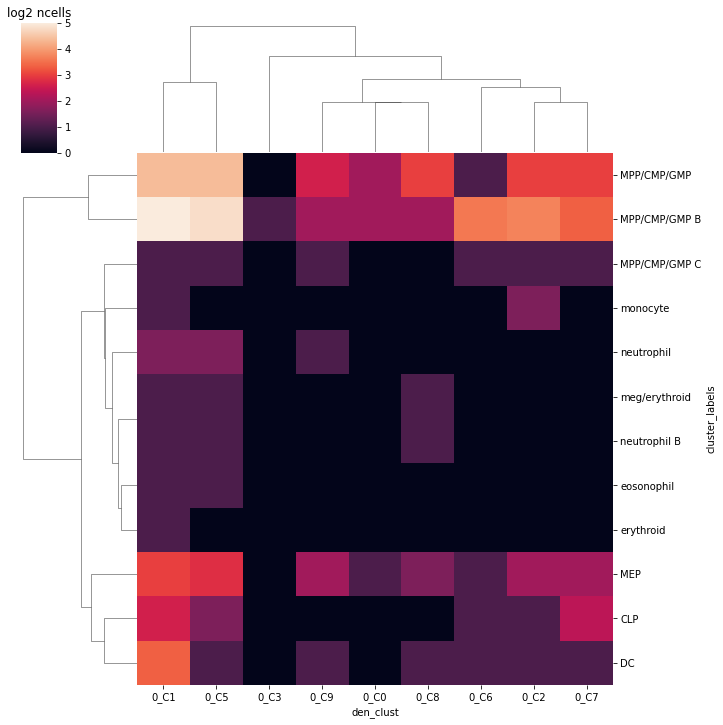

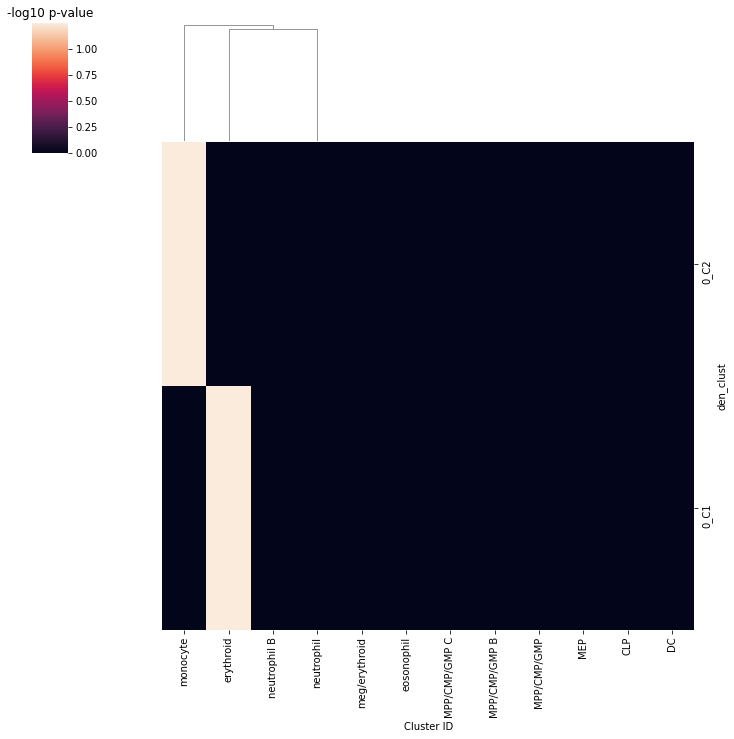

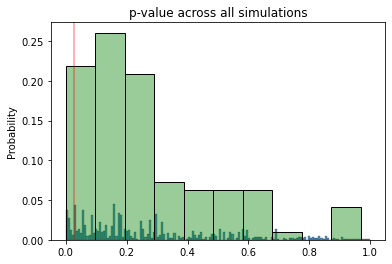

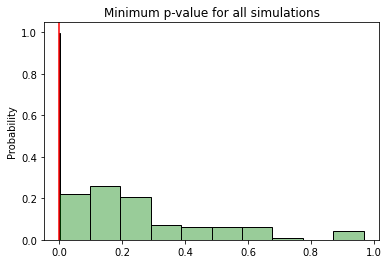

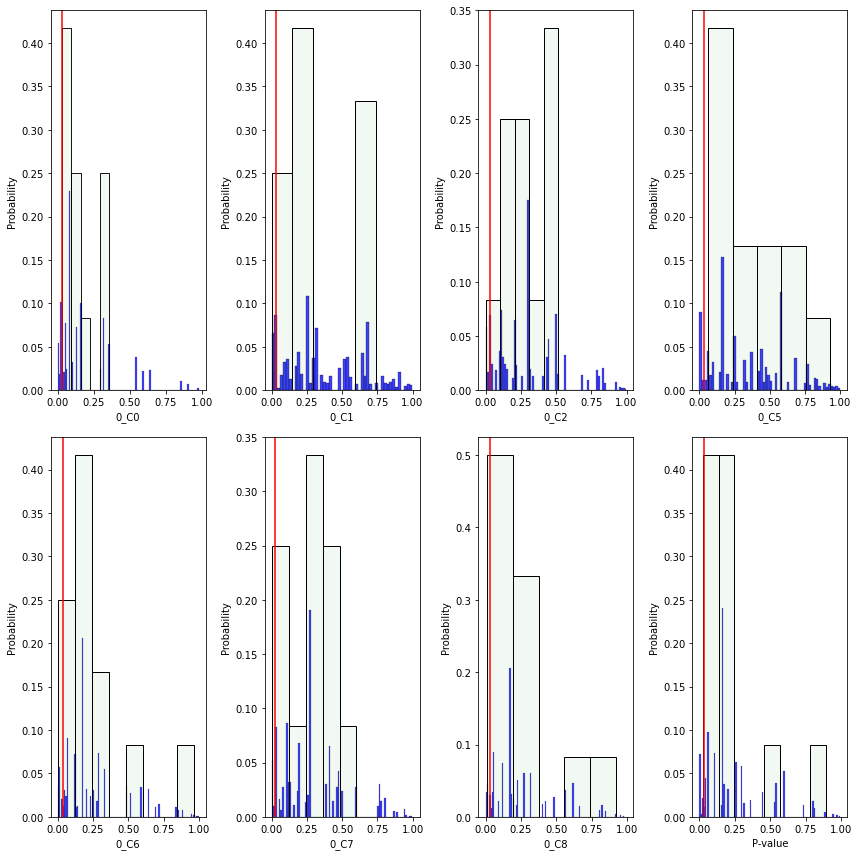

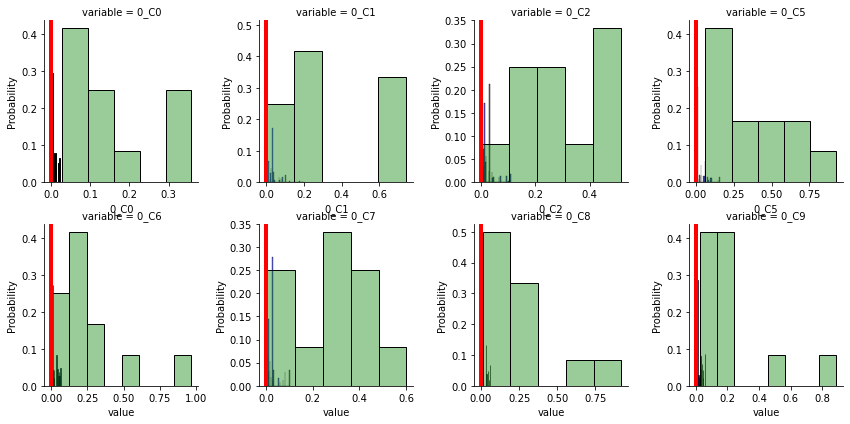

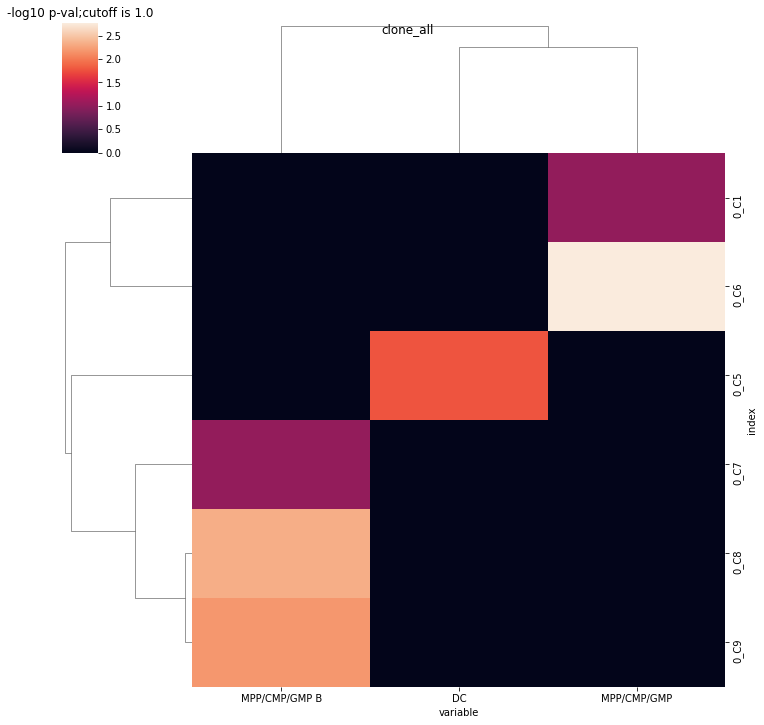

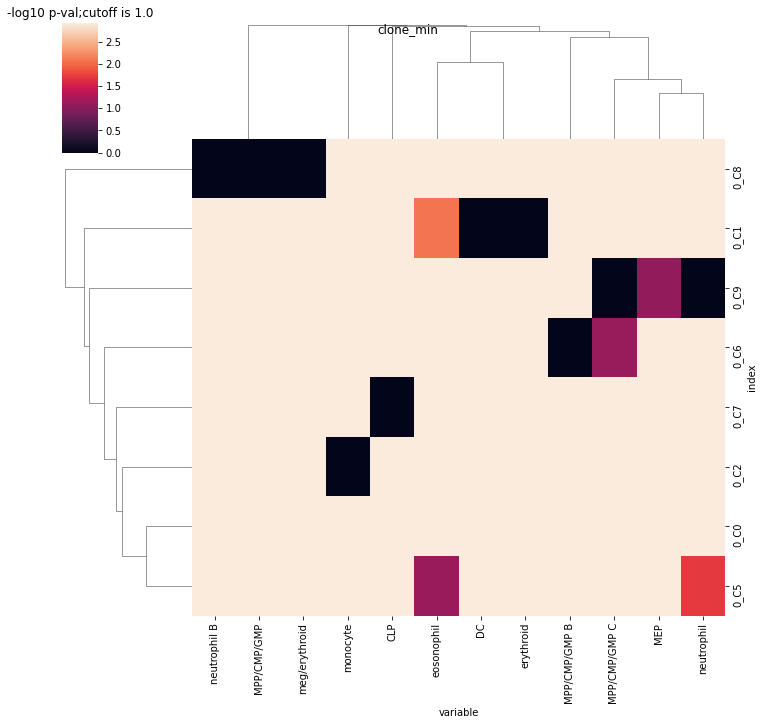

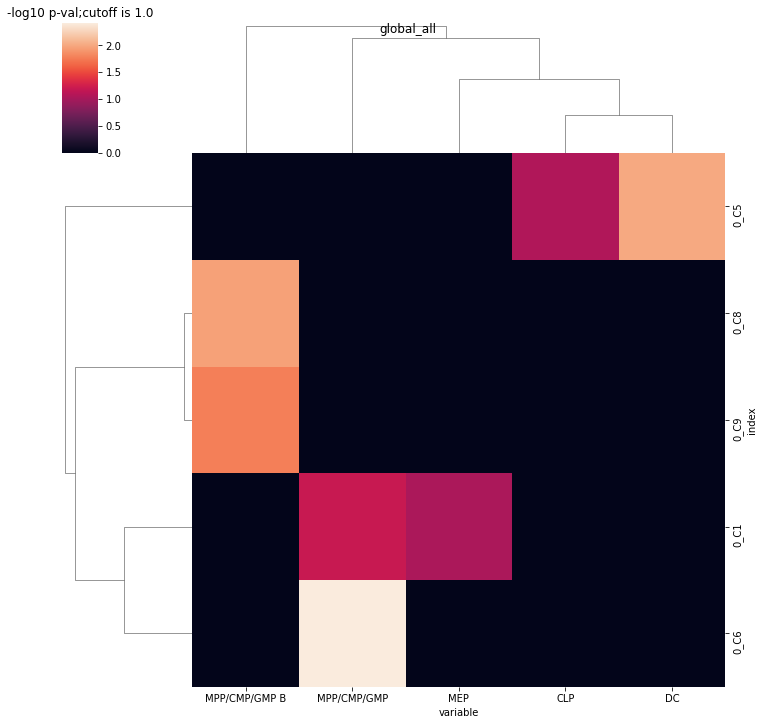

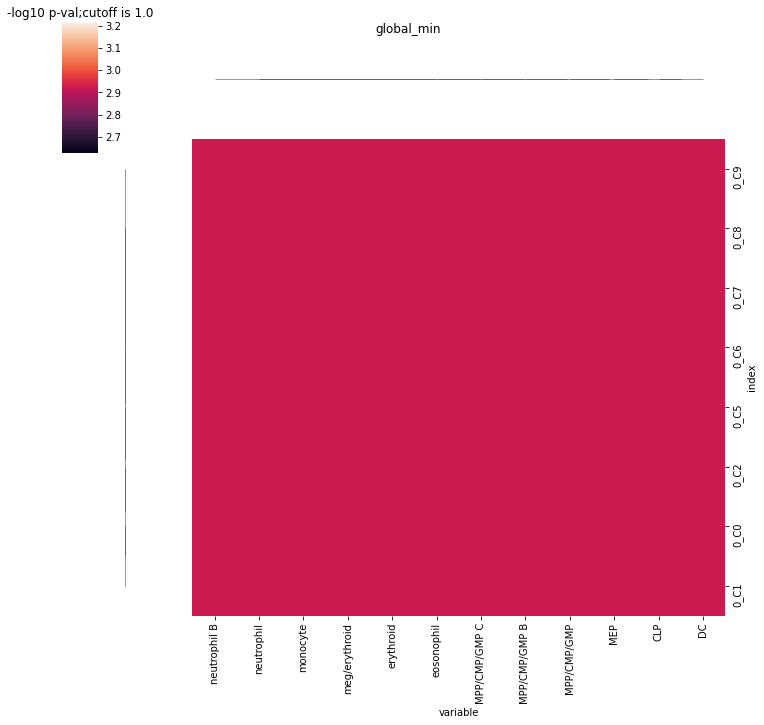

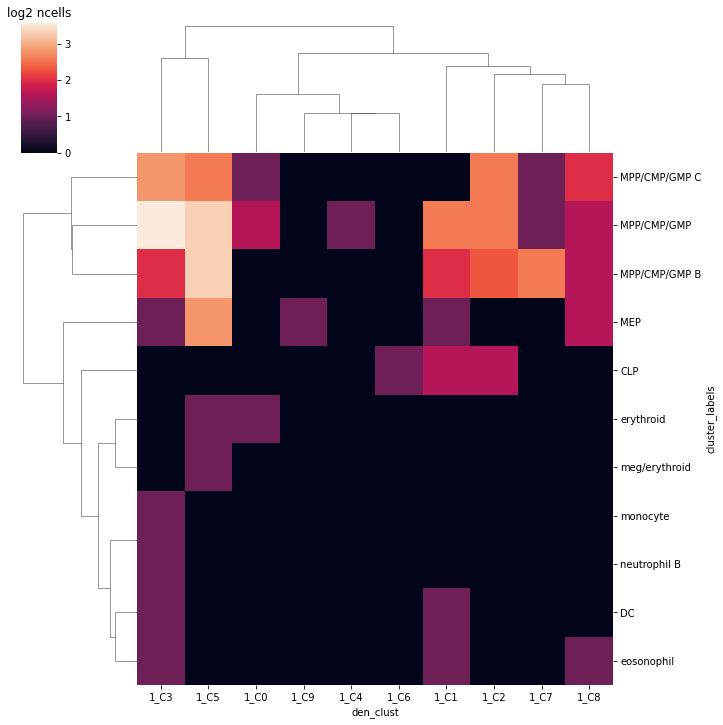

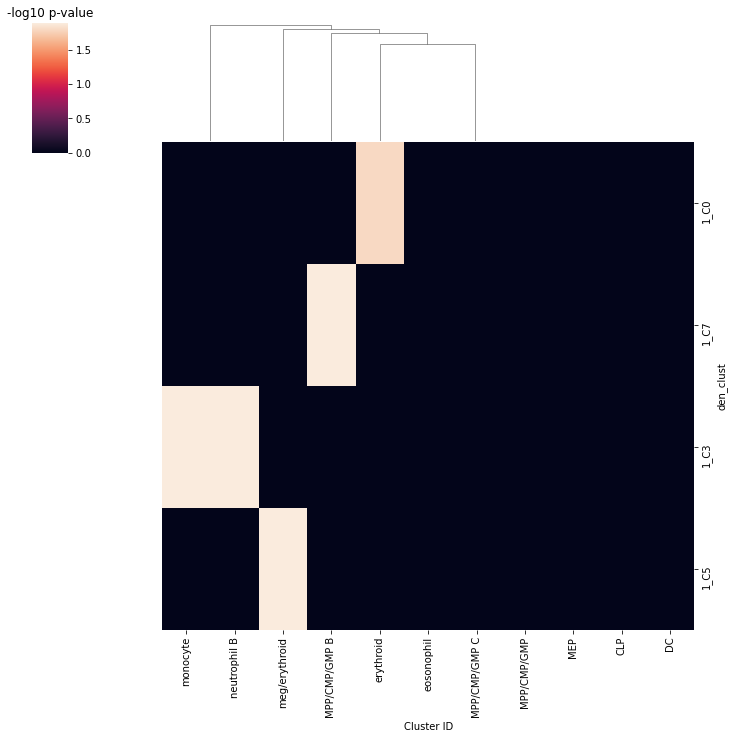

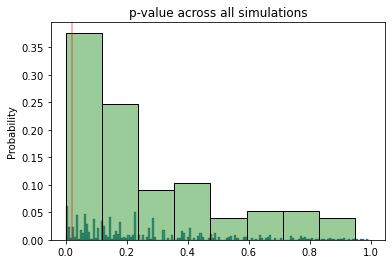

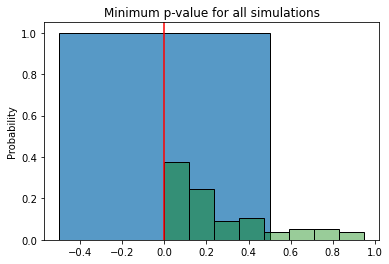

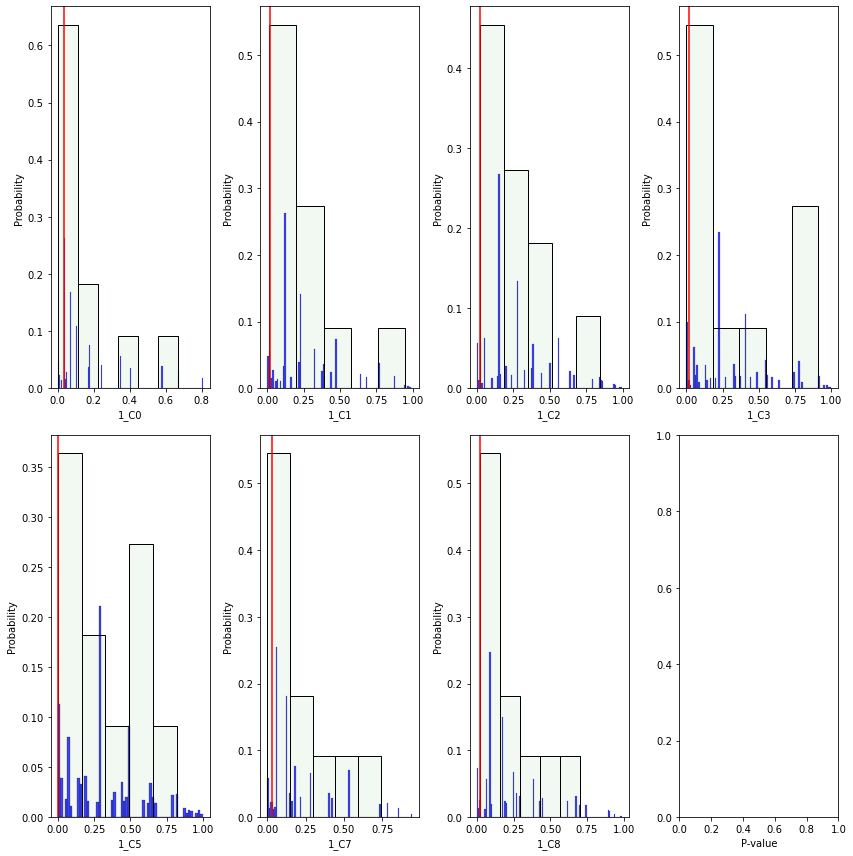

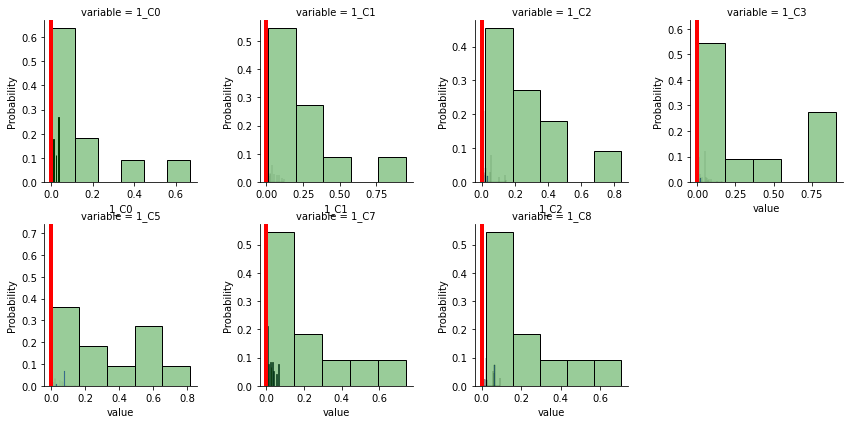

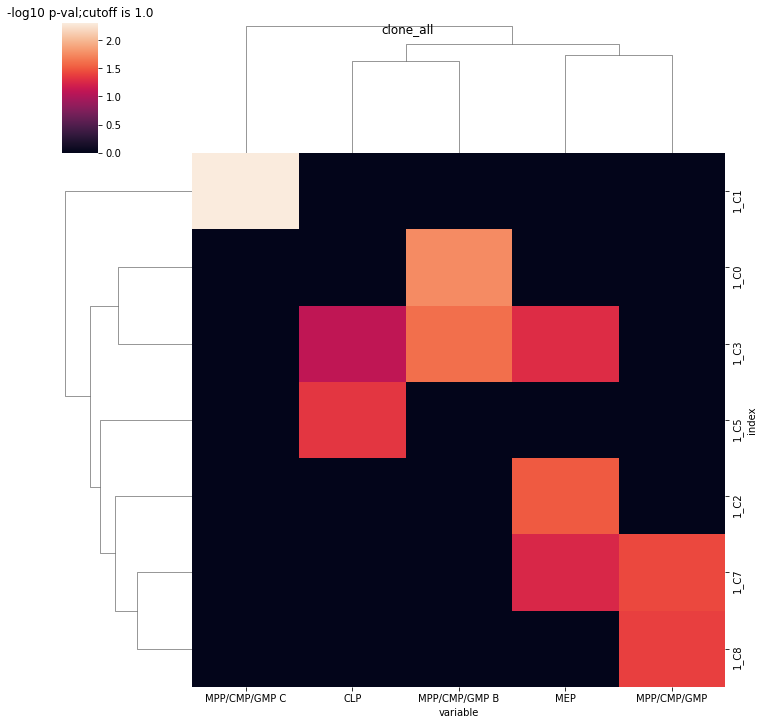

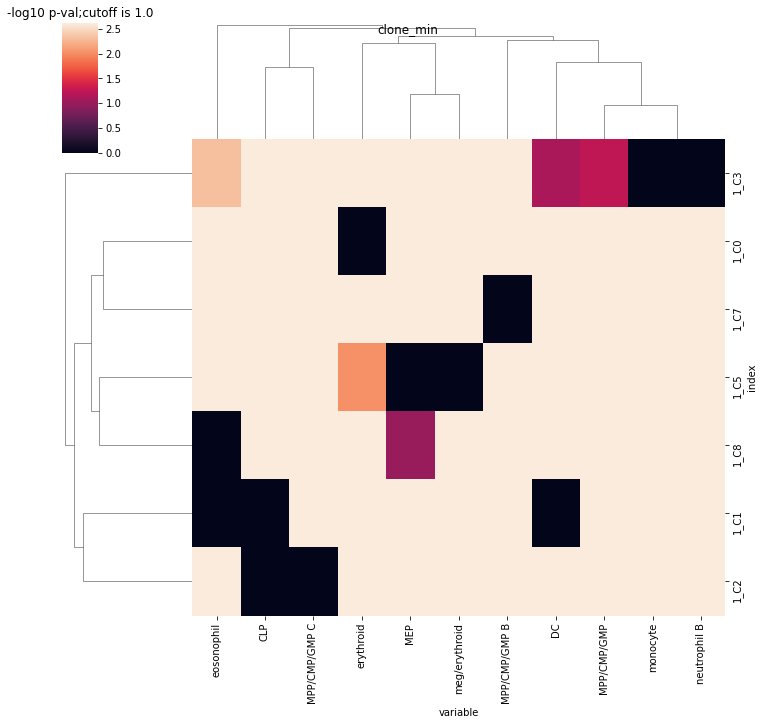

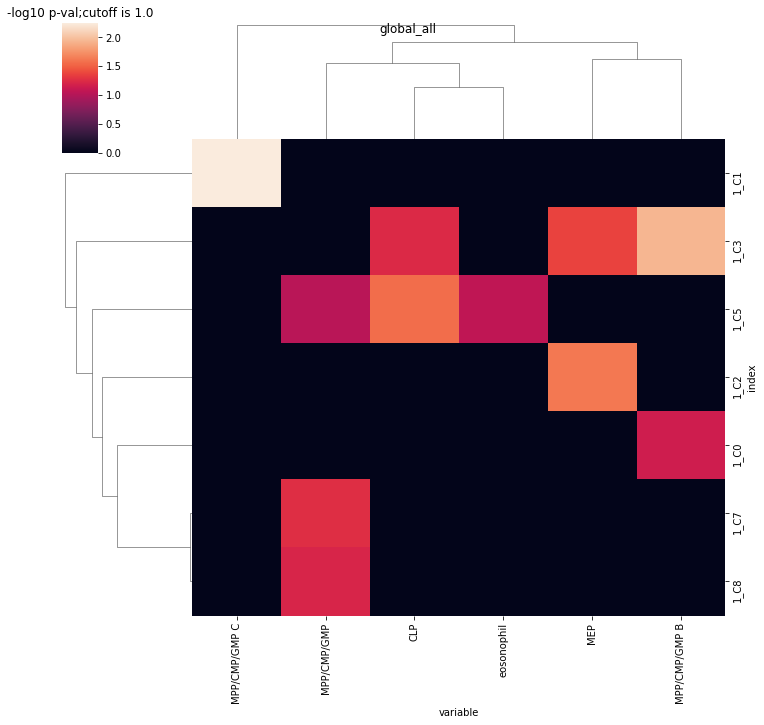

In [6]:
clone_col="den_clust"
atac_col = "cluster_labels"

for d in np.arange(N_DONORS):
    print("donor", d)
    d = str(d)
    curr_don_out = donor_out[int(d)]
    
    labels = labels_df[labels_df["donor"] == d]
    data = pd.merge(left=labels[[atac_col]], right=den_d[d], left_index=True, right_index=True)
    data = data.loc[~(data["cluster_labels"].isnull())]
    groups = data.groupby([atac_col, clone_col]).size().reset_index().rename({0:"count"}, axis=1)
    name_cond_size = groups.groupby([clone_col]).size()
    name_cond_size = name_cond_size[name_cond_size>min_clone_size]
    clones_filt = name_cond_size.index
    sizes = data.groupby(clone_col).size().sort_values(ascending=False)
    sizes = sizes.loc[clones_filt].sort_values(ascending=False)
    clones = clones_filt.values #np.unique(groups["name"])
    clone_map = {x:ind for ind,x in enumerate(clones)}
    atac_cl = np.unique(groups[atac_col])

    # Run init hypergeo
    cs.hypergeo_plots(groups, clones, atac_cl, sizes, p_thresh, atac_col,
                   clone_col, outdir)
    # RUN shuffle
    print("Running hypergeo shuffle and saving sig results")
    out_df, hyper_df, results_df, out_d = cs.run_data_and_shuffle(groups, curr_don_out, atac_col, clone_col, p_thresh, clones, 
                                                      atac_cl, n_shuffle=n_shuffle, figs_close=False, to_p_correct=False,
                                                                  n_cpus=n_cpus)    
    
    
    
#     output_df, bh_enrichment_df = cs.pipeline_groups_hypergeo(groups, clones, atac_cl, sizes,
#                                                          p_thresh=p_thresh, atac_col=atac_col, 
#                                                           clone_col=clone_col)
    

#     don_out = donor_out[int(d)]
#     bh_enrichment_df.to_csv(join(don_out, "hypergeo_input_padjusted.csv"))
#     output_df.to_csv(join(don_out, "hypergeo_input_padjusted_sigOnly.csv"))
    
#     if output_df.shape[0] == 0:   
#         g = sns.clustermap(-np.log10(bh_enrichment_df.fillna(1)), 
#                        row_cluster=False)
#         g.fig.suptitle("No groups were significant")
#     else:
#         g = sns.clustermap(-np.log10(bh_enrichment_df.loc[output_df.index].fillna(1)), 
#                        row_cluster=False)
#     g.ax_heatmap.set(xlabel="Cluster ID")
#     g.ax_cbar.set(title="-log10 p-value")
#     plt.savefig(join(don_out, "hypergeo_input_padjusted_sigOnly.png"))
    
    
#     init_bh_enrichment = cs.create_enrichment(groups, atac_col, clone_col, p_thresh,
#                                               clones=clones, atac_cl=atac_cl)
    
#     shuffle = cs.shuffle_hypergeo(groups, atac_col, clone_col, p_thresh, clones, atac_cl, 
#                                   n_shuffle=n_shuffle, to_parallel=True, n_cpus=24)

#     results_df, out_d = cs.get_out(shuffle, clones, init_bh_enrichment, p_thresh, 
#                                                           clone_map, atac_col, 
#                                                           outdir=join(don_out, "shuffle"),figs_close=False)
    
    
#     # plot just the counts
#     groups["log2_count"] = np.log2(groups["count"]+1)
#     g = sns.clustermap(groups.pivot(index="cluster_labels",columns="den_clust", values="log2_count").fillna(0))
#     plt.gca().set_title("log2 ncells")
#     plt.savefig(join(don_out, "ncells.png"))
    
# groups

In [ ]:
results_df

In [ ]:
# for ind, val in results_df[results_df["value"]<p_thresh].groupby("method"):
#     sns.clustermap(val.astype(object).pivot(index="index", columns="variable",values="value").fillna(1),
#                   vmax=p_thresh+0.1)
#     plt.suptitle(ind)

In [ ]:
# cell_pairs = []
# for ind,val in groups.iterrows():
#     cell_pairs.extend([[val["cluster_labels"], val["den_clust"]]]*val["count"])

# cell_pairs = np.array(cell_pairs)

# cell_pairs[:,1] = np.random.choice(cell_pairs[:,1], size= cell_pairs.shape[0],replace=False)
# cell_pairs

# grous_shuff = pd.DataFrame(cell_pairs,columns=[atac_col, clone_col]).groupby([atac_col, clone_col]).size().reset_index().rename({0:"count"}, axis=1)
# grous_shuff

In [ ]:
# def get_out(shuffle, clones, bh_enrichment_df, p_thresh, clone_map, atac_col, outdir, figs_close=False):
#     global_min, clone_min, global_all, clone_all = cs.get_shuffle_results(shuffle, clones, clone_map=clone_map)
#     out_all = cs.plot_glob_all(bh_enrichment_df, global_all, p_thresh, atac_col=atac_col, out_f=join(outdir, "shuffle_all.png"))
#     out_min = cs.plot_glob_min(bh_enrichment_df, global_min, p_thresh, atac_col=atac_col, out_f=join(outdir, "shuffle_min.png"))
#     out_cloneall = cs.plot_clone_all(bh_enrichment_df, clone_all, p_thresh, out_f=join(outdir, "shuffle_cloneMin.png"))
#     out_clonemin = cs.plot_clone_min(bh_enrichment_df, clone_min, p_thresh=p_thresh, out_f=join(outdir, "shuffle_cloneAll.png"))
#     if figs_close:
#         plt.close('all')
#     # save results df with p-vals for each
#     #results_df = pd.concat((out_all[1].melt(), out_min[1].melt(), out_cloneall[1].melt(), out_clonemin[1].melt()))
#     results_df = pd.concat((out_all[1].melt().assign(method="global_all"),out_min[1].melt().assign(method="global_min"),
#                             out_cloneall[1].melt().assign(method="clone_all"),
#                             out_clonemin[1].melt().assign(method="clone_min")),
#                            axis=0)
#     import pickle
#     out_d = {"sig_all":out_all, "sig_min":out_min,
#              "sig_cloneAll": out_cloneall, "sig_cloneMin": out_clonemin}
#     pickle.dump(out_d, open(join(outdir, "shuffle_results.p"), "wb"))
#     results_df.to_csv(join(outdir, "shuffle_results_pvals.tsv"),sep="\t")
#     return results_df, out_d


# results_df, out_d = get_out(shuffle, clones, init_bh_enrichment, p_thresh, 
#                                                       clone_map, atac_col, 
#                                                       outdir=join(don_out, "shuffle"))

In [ ]:
# for curr_don, don_lin_mt_ncells in lin_mt_ncells.groupby("donor"):
#     curr_don_mt = don_lin_mt_ncells.set_index(["cluster_labels","donor"])
#     #lin_mt_ncells_w = curr_don_mt.reset_index().melt(id_vars=["cluster_labels", "donor"], var_name="Variant", value_name="ncells")
#     don_lin_mt_ncells_df = don_lin_mt_ncells.pivot(index="cluster_labels", columns="Variants", values="ncells" )
#     sns.clustermap(don_lin_mt_ncells_df.fillna(0))